### Exercise 1
## 1 Loading the Dataset
First, we import the usual libraries as well as the digits dataset.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits

digits = load_digits()

print(digits.keys())

data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

print(data.dtype)

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])
float64


Now we restrict the data to images showing a 3 or 8.

In [3]:
cond = np.logical_or(target==3, target==8)
data = data[cond]
images = images[cond]
target = target[cond]
target_names = np.array([3,8])

And add a column of ones.

In [4]:
M, D = np.shape(data)
data = np.append(data, np.ones((M,1)), axis=1)

# 1.1 Classification with sklearn
In a first approach we use sklearn's predefined class LogisticRegression. Because of our additional column, we can set fit_intercept=False.

In [5]:
#import LoisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

#Perform cross-validation for 110 values of C between 10^-10 and 10^10
C_vals = np.logspace(-10,10,110)
score_means = np.empty(0)
for C in C_vals:
    LR = LogisticRegression(fit_intercept=False, C=C, solver='lbfgs', max_iter=100)
    scores = cross_val_score(LR, data, target, cv=10)
    score_means = np.append(score_means, scores.mean())

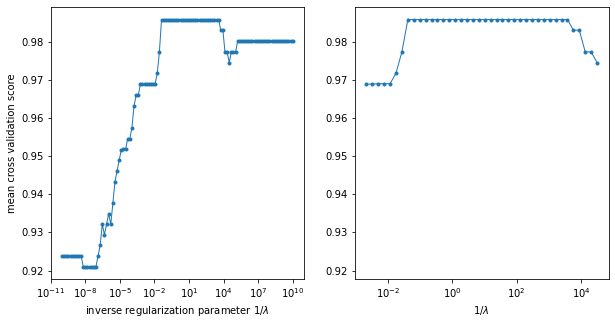

In [6]:
#plot the results
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
ax.plot(C_vals, score_means, marker="o", markersize=3, linewidth=1)
ax.set_xlabel("inverse regularization parameter $1/\lambda$")
ax.set_ylabel("mean cross validation score")
ax.set_xscale("log")
ax2 = fig.add_subplot(122, sharey=ax)
ax2.plot(C_vals[40:80], score_means[40:80], marker="o", markersize=3, linewidth=1)
ax2.set_xlabel("$1/\lambda$")
ax2.set_xscale("log")

We can clearly see in the figure above that the global maximum of the mean cross-validation score is reached on a pleateau that roughly reaches from 10^-1 to 10^3. Therefore we choose 10 as an optimal value for the inverse regularization parameter. This means $\lambda = 0.1$.

# 1.2 Optimization Methods
Next, we introduce some basic functions.

In [7]:
def sigmoid(z):
    return (1+np.exp(-z))**(-1)

#TODO: TESTEN
def gradient(beta, X, y):
    lamb = 0.1 #regularization parameter from previous task
    N,D = np.shape(X)
    
    beta = np.reshape(beta, (D,1)) 
    y = np.reshape(y, (N,1))
    
    z = np.multiply(-y,np.dot(X,beta))
    yX = np.multiply(-y,X)
    
    grad_unreg = 1/N * np.sum(np.multiply(sigmoid(z), yX), axis=0).reshape(D,1)
    
    return beta/lamb + grad_unreg

def predict(beta, X):
    N,D = np.shape(X)
    beta = np.reshape(beta, (D,1))
    p = sigmoid(np.dot(X, beta))
    return 2*(p>=.5)-1
    
def zero_one_loss(y_prediction, y_truth):
    y_prediction = np.ndarray.flatten(y_prediction)
    y_truth = np.ndarray.flatten(y_truth)
    return np.sum([not elem for elem in np.equal(y_prediction, y_truth)])


Now we use the functions defined above to implement several optimization methods.

In [9]:
#gradient descent
def gradient_descent(X, y, m, beta=None, tau0=0.01, gamma=0.001):
    #initialize default beta0
    if (beta is None): 
        beta = np.zeros(shape=(np.shape(X)[1],1))
    beta = np.reshape(beta, (np.shape(X)[1],1))
    
    #update rule
    for i in range(m):
        tau = tau0/(1 + gamma * i)
        beta = beta - tau * gradient(beta, X, y)
    return beta

#SG minibatch
def SG_minibatch(X, y, m, beta=None, tau0=0.01, gamma=0.001, minibatch_size=10):
    #initialize default beta0 
    N,D = np.shape(X)
    if (beta is None): 
        beta = np.zeros(shape=(D,1))
    beta = np.reshape(beta, (D,1))
    
    #update rule
    for i in range(m):
        tau = tau0/(1 + gamma * i)
        indices = np.random.randint(N, size=minibatch_size)
        minibatch = X[indices, :]
        y_minibatch = y[indices]
        beta = beta - tau * gradient(beta, minibatch, y_minibatch)
    return beta

#SG (single instance)
def SG(X, y, m, beta=None, tau0=0.01, gamma=0.001):
    return SG_minibatch(X, y, m, beta=beta, tau0=tau0, gamma=gamma, minibatch_size=1)

#SG momentum
def SG_momentum(X, y, m, beta=None, tau0=0.01, gamma=0.1, mu=0.2):
    #initialize default beta0, g0
    N,D = np.shape(X)
    if (beta is None): 
        beta = np.zeros(shape=(D,1))
    beta = np.reshape(beta, (D,1))
    g = np.zeros(shape=(D,1)) #initial momentum set to zero
    
    #update rule
    for i in range(m):
        tau = tau0/(1 + gamma * i)
        ind = np.random.randint(N, size=1)
        g = mu * g + (1-mu) * gradient(beta, X[ind,:], y[ind])
        beta = beta - tau * g
    return beta

#ADAM
def ADAM(X, y, m, beta=None, tau=1e-4, mu1=0.9, mu2=0.999, epsilon=1e-8):
    #initialize default beta0, g0, q0...
    N,D = np.shape(X)
    if (beta is None): 
        beta = np.zeros(shape=(D,1))
    beta = np.reshape(beta, (D,1))
    g = np.zeros(shape=(D,1)) #initial momentum set to zero
    q = 0
    
    #update rule
    for i in range(m):
        l = gradient(beta, X, y)
        g = (mu1 * g + (1-mu1) * l) / (1-mu1**(i+1))
        q = (mu2 * q + (1-mu2) * (l.T@l)[0][0]) / (1-mu2**(i+1))
        beta = beta - tau/(np.sqrt(q)+epsilon) * g
    return beta

#stochastic average gradient
def SAG(X, y, m, beta=None, tau0=0.01, gamma=0.001):
    #initialization
    N,D = np.shape(X)
    if (beta is None): 
        beta = np.zeros(shape=(D,1))
    beta = np.reshape(beta, (D,1))
    y = np.reshape(y, (N,1))
    
    z = np.multiply(-y, X@beta)
    yX = np.multiply(-y, X)
    g_stored = np.multiply(sigmoid(z), yX).T

    g = np.mean(g_stored, axis=1).reshape((D,1))
    
    lamb = 0.1 #use regularization parameter lambda from the previous exercise

    #update rule
    for i in range(m):
        tau = tau0/(1 + gamma * i)
        ind = np.random.randint(N) 
        
        g_ind = yX.T[:,[ind]] * sigmoid(-y[ind]*X[[ind],:]@beta)[0][0]
        
        g = g + 1/N * (g_ind - g_stored[:,[ind]])
        g_stored[:,[ind]] = g_ind 
        
        beta = beta * (1 - tau/lamb) - tau * g
    return beta

#dual coordinate ascent
def DCA(X, y, m, epsilon=1e-8):
    #initialization
    N,D = np.shape(X)
    lamb = 0.1
    alpha = np.random.rand(N,1)
    y = np.reshape(y, (N,1))
    
    ayX = np.multiply(alpha, np.multiply(y,X))
    
    beta = lamb * np.mean(ayX.T, axis=1).reshape((D,1))
        
    #update step
    for i in range(m):
        ind = np.random.randint(N) 
        
        dfdx = (y[ind]*X[[ind],:]@beta)[0][0] + np.log(alpha[ind]/(1-alpha[ind]))
        ddfdxdx = (lamb/N * X[[ind],:]@X.T[:,[ind]])[0][0] + 1/(alpha[ind]*(1-alpha[ind]))
        
        alpha_old = alpha[ind]
        alpha[ind] = alpha[ind] - dfdx/ddfdxdx
        if (alpha[ind] < epsilon):
            alpha[ind] = epsilon
        elif(alpha[ind] > 1-epsilon):
            alpha[ind] = 1-epsilon
            
        beta = beta + lamb/N * y[ind] * X.T[:,[ind]] * (alpha[ind] - alpha_old)
        return beta
    
#Newton/Raphson
def NR(X, y, m, beta=None):
    #initialization
    N,D = np.shape(X)
    lamb = 0.1
    if (beta is None): 
        beta = np.zeros(shape=(D,1))
    beta = np.reshape(beta, (D,1))
    y = np.reshape(y, (N,1))

    #update step
    for i in range(m):
        z = X@beta
        y_tilde = np.multiply(y, 1/sigmoid(np.multiply(y, z)))
        W = lamb/N * np.diag(np.diagonal(sigmoid(z)@sigmoid(-z).T))
        beta = np.linalg.inv(np.identity(D) + X.T@W@X) @ X.T @ W @ (z + y_tilde)
    return beta    
    

# 1.3 Comparison

In [10]:
from sklearn import model_selection

#class 1 corresponds to 3, class -1 to 8
target[target==3] = 1
target[target==8] = -1

X, X_test, y, y_test = model_selection.train_test_split(data, target, test_size=0.3, random_state=0)

In [11]:
#Learning Rate
kf = model_selection.KFold(n_splits=10)

for i in range(3):
    print()
    for j in range(3):
        print()
        for k in range(3):
            scores = []
            for train_index, validation_index in kf.split(X):
                X_train, X_validation = X[train_index], X[validation_index]
                y_train, y_validation = y[train_index], y[validation_index]

                tau0 = [0.001, 0.01, 0.1]
                mu = [0.1, 0.2, 0.5]
                gamma = [0.0001, 0.001, 0.01]

            #GD: good hyperparameters: tau0=0.001, gamma=0.01, mu does not matter
            #    beta = gradient_descent(X_train, y_train, 10, beta=None, tau0=tau0[i], gamma=gamma[j])

            #SG_minibatch: good hyperparameters: tau0=0.001, gamma=0.001, mu does not matter
            #    beta = SG_minibatch(X_train, y_train, 150, beta=None, tau0=tau0[i], gamma=gamma[j], minibatch_size=10)

            #SG: good hyperparameters: tau0=0.001, gamma=0.001, mu does not matter
            #    beta = SG(X_train, y_train, 150, beta=None, tau0=tau0[i], gamma=gamma[j])

            #SG momentum: good hyperparameters: tau0=0.001, gamma=0.01, mu=0.2
            #    beta = SG_momentum(X_train, y_train, 150, beta=None, tau0=tau0[i], gamma=gamma[j], mu=mu[k])

            #ADAM: good hyperparameters: tau0=0.1, gamma, mu don't not matter
                beta = ADAM(X_train, y_train, 10, beta=None, tau=tau0[i], mu1=0.9, mu2=0.999, epsilon=1e-8)

            #SAG: good hyperparameters: tau0=0.1, mu don't matter, gamma=0.0001
            #    beta = SAG(X_train, y_train, 150, beta=None, tau0=tau0[i], gamma=gamma[j])

            #DCA: good hyperparameters: tau0, gamma, mu don't matter
            #    beta = DCA(X_train, y_train, 150, epsilon=1e-8)

            #NR: good hyperparameters: tau0, gamma, mu don't matter
            #    beta = NR(X_train, y_train, 10, beta=None)

                scores.append(zero_one_loss(predict(beta, X_validation), y_validation))

            print("tau=",tau0[i], ", mu=", mu[k], ", gamma=", gamma[j],":")
            print("average loss:", np.mean(scores))



tau= 0.001 , mu= 0.1 , gamma= 0.0001 :
average loss: 2.8
tau= 0.001 , mu= 0.2 , gamma= 0.0001 :
average loss: 2.8
tau= 0.001 , mu= 0.5 , gamma= 0.0001 :
average loss: 2.8

tau= 0.001 , mu= 0.1 , gamma= 0.001 :
average loss: 2.8
tau= 0.001 , mu= 0.2 , gamma= 0.001 :
average loss: 2.8
tau= 0.001 , mu= 0.5 , gamma= 0.001 :
average loss: 2.8

tau= 0.001 , mu= 0.1 , gamma= 0.01 :
average loss: 2.8
tau= 0.001 , mu= 0.2 , gamma= 0.01 :
average loss: 2.8
tau= 0.001 , mu= 0.5 , gamma= 0.01 :
average loss: 2.8


tau= 0.01 , mu= 0.1 , gamma= 0.0001 :
average loss: 2.8
tau= 0.01 , mu= 0.2 , gamma= 0.0001 :
average loss: 2.8
tau= 0.01 , mu= 0.5 , gamma= 0.0001 :
average loss: 2.8

tau= 0.01 , mu= 0.1 , gamma= 0.001 :
average loss: 2.8
tau= 0.01 , mu= 0.2 , gamma= 0.001 :
average loss: 2.8
tau= 0.01 , mu= 0.5 , gamma= 0.001 :
average loss: 2.8

tau= 0.01 , mu= 0.1 , gamma= 0.01 :
average loss: 2.8
tau= 0.01 , mu= 0.2 , gamma= 0.01 :
average loss: 2.8
tau= 0.01 , mu= 0.5 , gamma= 0.01 :
average los

At last we measure the convergence speed of each algorithm.

In [12]:
import pandas as pd
import time
iterations = np.array([1,3,5,8,10,30,50,80,100,300,500,800,1000])

data = pd.DataFrame(columns=["method","iterations","time","training error", "test error"])
for i in iterations:
    print("i=",i)
    #GD
    start_time = time.time()
    beta = gradient_descent(X, y, i, beta=None, tau0=0.001, gamma=0.01)
    T = time.time() - start_time
    training_error = zero_one_loss(predict(beta,X), y)/len(y)
    test_error = zero_one_loss(predict(beta,X_test), y_test)/len(y_test)
    data = data.append({"method":"GD", "iterations":i, 
                        "time":T, "training error":training_error, 
                        "test error":test_error}, ignore_index=True)

    #SG minibatch
    start_time = time.time()   
    beta = SG_minibatch(X, y, i, beta=None, tau0=0.001, gamma=0.001, minibatch_size=10)
    T = time.time() - start_time
    training_error = zero_one_loss(predict(beta,X), y)/len(y)
    test_error = zero_one_loss(predict(beta,X_test), y_test)/len(y_test)
    data = data.append({"method":"SG_minibatch", "iterations":i, 
                        "time":T, "training error":training_error, 
                        "test error":test_error}, ignore_index=True)
    
    #SG
    start_time = time.time()
    beta = SG(X, y, i, beta=None, tau0=0.001, gamma=0.001)
    T = time.time() - start_time
    training_error = zero_one_loss(predict(beta,X), y)/len(y)
    test_error = zero_one_loss(predict(beta,X_test), y_test)/len(y_test)
    data = data.append({"method":"SG", "iterations":i, 
                        "time":T, "training error":training_error, 
                        "test error":test_error}, ignore_index=True)
    
    #SG_momentum
    start_time = time.time()
    beta = SG_momentum(X, y, i, beta=None, tau0=0.001, gamma=0.01, mu=0.2)
    T = time.time() - start_time
    training_error = zero_one_loss(predict(beta,X), y)/len(y)
    test_error = zero_one_loss(predict(beta,X_test), y_test)/len(y_test)
    data = data.append({"method":"SG_momentum", "iterations":i, 
                        "time":T, "training error":training_error, 
                        "test error":test_error}, ignore_index=True)
    
    #ADAM
    start_time = time.time()
    beta = ADAM(X, y, i, beta=None, tau=0.1, mu1=0.9, mu2=0.999, epsilon=1e-8)
    T = time.time() - start_time
    training_error = zero_one_loss(predict(beta,X), y)/len(y)
    test_error = zero_one_loss(predict(beta,X_test), y_test)/len(y_test)
    data = data.append({"method":"ADAM", "iterations":i, 
                        "time":T, "training error":training_error, 
                        "test error":test_error}, ignore_index=True)
        
    #SAG
    start_time = time.time()
    beta = SAG(X, y, i, beta=None, tau0=0.1, gamma=0.0001)
    T = time.time() - start_time
    training_error = zero_one_loss(predict(beta,X), y)/len(y)
    test_error = zero_one_loss(predict(beta,X_test), y_test)/len(y_test)
    data = data.append({"method":"SAG", "iterations":i, 
                        "time":T, "training error":training_error, 
                        "test error":test_error}, ignore_index=True)

    #DAC
    start_time = time.time()
    beta = DCA(X, y, i, epsilon=1e-8)
    T = time.time() - start_time
    training_error = zero_one_loss(predict(beta,X), y)/len(y)
    test_error = zero_one_loss(predict(beta,X_test), y_test)/len(y_test)
    data = data.append({"method":"DAC", "iterations":i, 
                        "time":T, "training error":training_error, 
                        "test error":test_error}, ignore_index=True)
    
    #NR
    start_time = time.time()
    beta = NR(X, y, i, beta=None)
    T = time.time() - start_time
    training_error = zero_one_loss(predict(beta,X), y)/len(y)
    test_error = zero_one_loss(predict(beta,X_test), y_test)/len(y_test)
    data = data.append({"method":"NR", "iterations":i, 
                        "time":T, "training error":training_error, 
                        "test error":test_error}, ignore_index=True)
    

i= 1
i= 3
i= 5
i= 8
i= 10
i= 30
i= 50
i= 80
i= 100
i= 300
i= 500


<ipython-input-9-e61d1fb07541>:66: RuntimeWarning: overflow encountered in double_scalars
  q = (mu2 * q + (1-mu2) * (l.T@l)[0][0]) / (1-mu2**(i+1))


i= 800
i= 1000


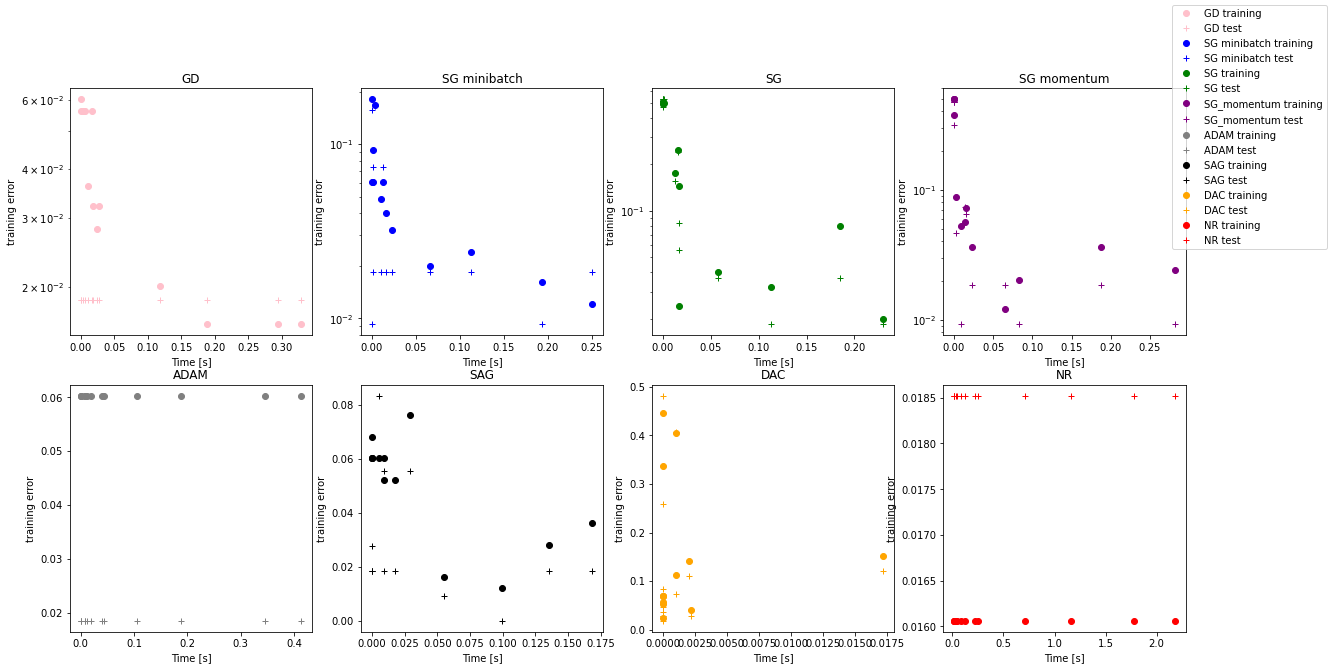

In [15]:
data
fig = plt.figure(248, figsize = (20, 10))

ax1 = fig.add_subplot(241)
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("training error")
ax1.set_yscale("log")
ax1.set_title("GD")
data_GD = data[data["method"]=="GD"]
ax1.plot(data_GD[["time"]], data_GD[["training error"]], label="GD training", marker="o", linestyle="None", color="pink")
ax1.plot(data_GD[["time"]], data_GD[["test error"]], label="GD test", marker="+", linestyle="None", color="pink")

ax2 = fig.add_subplot(242)
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("training error")
ax2.set_yscale("log")
ax2.set_title("SG minibatch")
data_SG_minibatch = data[data["method"]=="SG_minibatch"]
ax2.plot(data_SG_minibatch[["time"]], data_SG_minibatch[["training error"]], label="SG minibatch training", marker="o", linestyle="None", color="blue")
ax2.plot(data_SG_minibatch[["time"]], data_SG_minibatch[["test error"]], label="SG minibatch test", marker="+", linestyle="None", color="blue")

ax3 = fig.add_subplot(243)
ax3.set_xlabel("Time [s]")
ax3.set_ylabel("training error")
ax3.set_yscale("log")
ax3.set_title("SG")
data_SG = data[data["method"]=="SG"]
ax3.plot(data_SG[["time"]], data_SG[["training error"]], label="SG training", marker="o", linestyle="None", color="green")
ax3.plot(data_SG[["time"]], data_SG[["test error"]], label="SG test", marker="+", linestyle="None", color="green")

ax4 = fig.add_subplot(244)
ax4.set_xlabel("Time [s]")
ax4.set_ylabel("training error")
ax4.set_yscale("log")
ax4.set_title("SG momentum")
data_SG_momentum = data[data["method"]=="SG_momentum"]
ax4.plot(data_SG_momentum[["time"]], data_SG_momentum[["training error"]], label="SG_momentum training", marker="o", linestyle="None", color="purple")
ax4.plot(data_SG_momentum[["time"]], data_SG_momentum[["test error"]], label="SG_momentum test", marker="+", linestyle="None", color="purple")

ax5 = fig.add_subplot(245)
ax5.set_xlabel("Time [s]")
ax5.set_ylabel("training error")
ax5.set_title("ADAM")
data_ADAM = data[data["method"]=="ADAM"]
ax5.plot(data_ADAM[["time"]], data_ADAM[["training error"]], label="ADAM training", marker="o", linestyle="None", color="grey")
ax5.plot(data_ADAM[["time"]], data_ADAM[["test error"]], label="ADAM test", marker="+", linestyle="None", color="grey")

ax6 = fig.add_subplot(246)
ax6.set_xlabel("Time [s]")
ax6.set_ylabel("training error")
ax6.set_title("SAG")
data_SAG = data[data["method"]=="SAG"]
ax6.plot(data_SAG[["time"]], data_SAG[["training error"]], label="SAG training", marker="o", linestyle="None", color="black")
ax6.plot(data_SAG[["time"]], data_SAG[["test error"]], label="SAG test", marker="+", linestyle="None", color="black")

ax7 = fig.add_subplot(247)
ax7.set_xlabel("Time [s]")
ax7.set_ylabel("training error")
ax7.set_title("DAC")
data_DAC = data[data["method"]=="DAC"]
ax7.plot(data_DAC[["time"]], data_DAC[["training error"]], label="DAC training", marker="o", linestyle="None", color="orange")
ax7.plot(data_DAC[["time"]], data_DAC[["test error"]], label="DAC test", marker="+", linestyle="None", color="orange")

ax8 = fig.add_subplot(248)
ax8.set_xlabel("Time [s]")
ax8.set_ylabel("training error")
ax8.set_title("NR")
data_NR = data[data["method"]=="NR"]
ax8.plot(data_NR[["time"]], data_NR[["training error"]], label="NR training", marker="o", linestyle="None", color="red")
ax8.plot(data_NR[["time"]], data_NR[["test error"]], label="NR test", marker="+", linestyle="None", color="red")


fig.legend()

In most of the cases (every method except for ADAM and Newton/Raphson) we can see a decay of the errors with computation time. In many cases (for example GD) it seems to be exponential (at least in the beginning). Furthermore, qualitatively the behavior of ADAM and Newton/Raphson is similar. We learned in that both algorithms make use of the idea to consider second order terms of the loss function (i.e. its Taylor expansion). This could explain their similarities.